## 1. Setup & Configuration

In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout, Add, Bidirectional, LSTM, MaxPooling1D
from tensorflow.keras.regularizers import l2

In [3]:
# 프로젝트 루트 경로 설정
PROJECT_ROOT = '/content/drive/MyDrive/Colab Notebooks/HAR_Research_Project'
sys.path.append(PROJECT_ROOT)

In [4]:
# utils.py 로드
from utils import squeeze_excite_block, cbam_block, transformer_encoder, categorical_focal_loss

### 1.1. 실험마다 변경할 변수들

In [5]:
# 1. 데이터셋: 'UCI', 'WISDM', 'UniMiB', 'PAMAP2', 'Opportunity'
TARGET_DATASET = 'WISDM'

# 2. 모델: 'standard_resnet', 'cnn_bilstm', 'se_resnet', 'cbam_resnet', 'resnet_transformer'
TARGET_MODEL = 'standard_resnet'

# 3. 실험 태그 (파일명 중복 방지용) - 날짜 또는 실험 특징 기입
EXPERIMENT_TAG = '20251203'

# 4. 하이퍼파라미터
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.0005

# 파일 ID 생성 (자동)
FILE_ID = f"{TARGET_DATASET}_{TARGET_MODEL}_{EXPERIMENT_TAG}"
print(f"🚀 Experiment Initialized: {FILE_ID}")

🚀 Experiment Initialized: WISDM_standard_resnet_20251203


## 2. Data Loading & Preprocessing

In [6]:
def load_dataset(name):
    print(f"\n[Data Loading] {name} 데이터셋 로드 중...")
    data_dir = f'{PROJECT_ROOT}/data/processed'

    try:
        X = np.load(f'{data_dir}/{name}_X.npy')
        y = np.load(f'{data_dir}/{name}_y.npy')
    except FileNotFoundError:
        raise FileNotFoundError(f"❌ 파일을 찾을 수 없습니다. {data_dir} 확인 필요.")

    # [Safety] 극소수 클래스 필터링 (Stratify 에러 방지)
    unique, counts = np.unique(y, return_counts=True)
    if np.min(counts) < 5:
        print("⚠️ 극소수 샘플 클래스 제거 중...")
        mask = np.isin(y, unique[counts >= 5])
        X, y = X[mask], y[mask]
        # 라벨 리매핑
        label_map = {old: new for new, old in enumerate(np.unique(y))}
        y = np.vectorize(label_map.get)(y)

    # One-hot Encoding
    n_classes = len(np.unique(y))
    y_cat = tf.keras.utils.to_categorical(y, n_classes)

    # Train/Val/Test Split (6:2:2) with Error Handling
    try:
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y_cat, test_size=0.4, random_state=42, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
        )
    except ValueError:
        print("⚠️ Stratify failed (Data imbalance). Switching to random split.")
        X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test, n_classes

In [7]:
# 데이터 로드 실행
X_train, y_train, X_val, y_val, X_test, y_test, n_classes = load_dataset(TARGET_DATASET)
window_size = X_train.shape[1] # (N, 128, 3)에서 128을 동적으로 가져옴
n_channels = X_train.shape[2]  # 채널 수
print(f"✅ Data Ready: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
print(f"Preprocessing Info: Window Size={window_size}, Channels={n_channels}")
print(f"Note: Overlap=50% (Fixed in Preprocessing step), No Augmentation")


[Data Loading] WISDM 데이터셋 로드 중...
✅ Data Ready: Train=(10185, 128, 3), Val=(3395, 128, 3), Test=(3395, 128, 3)
Preprocessing Info: Window Size=128, Channels=3
Note: Overlap=50% (Fixed in Preprocessing step), No Augmentation


## 3. Model Architecture Builder

In [8]:
def resnet_block(inputs, filters, stride=1, attention=None):
    shortcut = inputs
    if stride > 1 or inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Conv1D(filters, 3, strides=stride, padding='same', kernel_regularizer=l2(5e-5))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv1D(filters, 3, strides=1, padding='same', kernel_regularizer=l2(5e-5))(x)
    x = BatchNormalization()(x)

    if attention == 'se': x = squeeze_excite_block(x)
    elif attention == 'cbam': x = cbam_block(x)

    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    return x

In [9]:
def build_universal_model(input_shape, n_classes, model_type):
    inputs = Input(shape=input_shape)

    # [Type A] CNN + Bi-LSTM
    if model_type == 'cnn_bilstm':
        x = Conv1D(64, 3, padding='same', activation='swish')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Conv1D(128, 3, padding='same', activation='swish')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Bidirectional(LSTM(64, return_sequences=False))(x)
        x = Dropout(0.4)(x)
        outputs = Dense(n_classes, activation='softmax')(x)
        return Model(inputs, outputs, name='CNN_BiLSTM')

    # [Type B] ResNet Variants
    x = Conv1D(64, 7, strides=2, padding='same', kernel_regularizer=l2(5e-5))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    att = None
    if 'se' in model_type: att = 'se'
    if 'cbam' in model_type: att = 'cbam'

    x = resnet_block(x, 64, 1, att)
    x = resnet_block(x, 128, 2, att)
    x = resnet_block(x, 256, 2, att)

    if 'transformer' in model_type:
        x = transformer_encoder(x, 64, 4, 128, 0.2)
        x = GlobalAveragePooling1D()(x)
    else:
        x = GlobalAveragePooling1D()(x)

    x = Dropout(0.3)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    return Model(inputs, outputs, name=f'{model_type.upper()}')

In [10]:
# 모델 생성
model = build_universal_model(X_train.shape[1:], n_classes, TARGET_MODEL)

In [11]:
model.summary()

Model: "STANDARD_RESNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 64, 64)    │      1,408 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 64, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 64, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 32, 128)   │     24,704 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 32, 128)   │     49,280 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 32, 128)   │      8,320 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 128)   │          0 │ batch_normalizat

 Total params: 443,782 (1.69 MB)

 Trainable params: 441,094 (1.68 MB)

 Non-trainable params: 2,688 (10.50 KB)

## 4. Training Loop

In [12]:
model.compile(
    loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=0.5),
    metrics=['accuracy']
)

In [13]:
checkpoint_path = f'{PROJECT_ROOT}/checkpoints/best_model_{FILE_ID}.keras'

In [14]:
print(f"\n⚡ Start Training: {FILE_ID} ...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy')
    ]
)


⚡ Start Training: WISDM_standard_resnet_20251203 ...
Epoch 1/150
160/160 - 23s - 143ms/step - accuracy: 0.8464 - loss: 0.0940 - val_accuracy: 0.7302 - val_loss: 0.1371
Epoch 2/150
160/160 - 1s - 7ms/step - accuracy: 0.9500 - loss: 0.0530 - val_accuracy: 0.9567 - val_loss: 0.0500
Epoch 3/150
160/160 - 1s - 7ms/step - accuracy: 0.9680 - loss: 0.0448 - val_accuracy: 0.9708 - val_loss: 0.0443
Epoch 4/150
160/160 - 1s - 6ms/step - accuracy: 0.9722 - loss: 0.0412 - val_accuracy: 0.9703 - val_loss: 0.0419
Epoch 5/150
160/160 - 1s - 6ms/step - accuracy: 0.9826 - loss: 0.0369 - val_accuracy: 0.9585 - val_loss: 0.0423
Epoch 6/150
160/160 - 1s - 7ms/step - accuracy: 0.9818 - loss: 0.0354 - val_accuracy: 0.9761 - val_loss: 0.0371
Epoch 7/150
160/160 - 1s - 6ms/step - accuracy: 0.9822 - loss: 0.0331 - val_accuracy: 0.9685 - val_loss: 0.0384
Epoch 8/150
160/160 - 1s - 7ms/step - accuracy: 0.9757 - loss: 0.0341 - val_accuracy: 0.9788 - val_loss: 0.0338
Epoch 9/150
160/160 - 1s - 8ms/step - accuracy:

In [15]:
# 학습 이력 CSV 저장
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(f'{PROJECT_ROOT}/results/logs/history_{FILE_ID}.csv', index=False)

## 5. Final Report & Visualization (Prof. Style + Auto Save)

In [16]:
# 1. Best Model 로드 (Evaluation Mode)
best_model = load_model(
    checkpoint_path,
    custom_objects={
        'focal_loss_fixed': categorical_focal_loss(),
        'squeeze_excite_block': squeeze_excite_block,
        'cbam_block': cbam_block,
        'transformer_encoder': transformer_encoder
    },
    compile=False # 평가용이므로 컴파일 불필요
)

# 2. 예측 수행
y_pred_probs = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3. 라벨 정의
if TARGET_DATASET == 'UCI':
    labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

elif TARGET_DATASET == 'WISDM':
    labels = ['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

elif TARGET_DATASET == 'UniMiB':
    labels = [
        'Walking', 'Running', 'GoingUpS', 'GoingDownS', 'Jumping',
        'SittingDown', 'StandingUpFS', 'LyingDownFS', 'StandingUpFL',
        'FallingForw', 'FallingBack', 'FallingRight', 'FallingLeft',
        'Syncope', 'FallingBackSC', 'FallingWithPS', 'HittingObstacle'
    ]

elif TARGET_DATASET == 'PAMAP2':
    labels = [
        'Lying', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling',
        'Nordic_Walk', 'Ascending', 'Descending', 'Vacuum', 'Ironing', 'Rope_Jump'
    ]

elif TARGET_DATASET == 'Opportunity':
    labels = ['Stand', 'Walk', 'Sit', 'Lie']

else:
    # 예외 처리: 라벨 개수만큼 숫자로 표시
    labels = [str(i) for i in range(n_classes)]

In [21]:
# -----------------------------------------------------------------------------
# [상세 분석 1] 전체 성능 지표 (Overall Metrics)
# -----------------------------------------------------------------------------
accuracy = accuracy_score(y_true, y_pred)
# Macro: 클래스별 점수의 단순 평균 (소수 클래스 성능 중시)
f1_macro = f1_score(y_true, y_pred, average='macro')
# Weighted: 샘플 수에 가중치를 둔 평균 (전체적인 성능 중시)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"Dataset: {TARGET_DATASET} | Model: {TARGET_MODEL}")
print("-" * 40)
print(f"✅ Final Test Accuracy:   {accuracy:.4f}")
print(f"✅ F1-Score (Macro):      {f1_macro:.4f}")
print(f"✅ F1-Score (Weighted):   {f1_weighted:.4f}")

Dataset: WISDM | Model: standard_resnet
----------------------------------------
✅ Final Test Accuracy:   0.9885
✅ F1-Score (Macro):      0.9833
✅ F1-Score (Weighted):   0.9885


In [18]:
# -----------------------------------------------------------------------------
# [상세 분석 2] 클래스별 세부 성적표 (Class-wise Report)
# -----------------------------------------------------------------------------
# classification_report를 딕셔너리로 받아 DataFrame으로 변환
clf_report_dict = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
df_report = pd.DataFrame(clf_report_dict).transpose()

# 불필요한 행(accuracy 등) 정리 및 보기 좋게 포맷팅
print("\n📋 [Class-wise Performance Report]")
display(df_report)

# CSV로 저장
df_report.to_csv(f'{PROJECT_ROOT}/results/logs/detail_report_{FILE_ID}.csv')
print(f"   -> Saved details to: results/logs/detail_report_{FILE_ID}.csv")


📋 [Class-wise Performance Report]


,precision,recall,f1-score,support
Jogging,0.996187,0.993346,0.994764,1052.000000
Walking,0.996160,0.992349,0.994251,1307.000000
Upstairs,0.971129,0.961039,0.966057,385.000000
Downstairs,0.959752,0.990415,0.974843,313.000000
Sitting,0.984043,0.989305,0.986667,187.000000
Standing,0.980263,0.986755,0.983498,151.000000
accuracy,0.988513,0.988513,0.988513,0.988513
macro avg,0.981256,0.985535,0.983347,3395.000000
weighted avg,0.988599,0.988513,0.988527,3395.000000


   -> Saved details to: results/logs/detail_report_WISDM_standard_resnet_20251203.csv


   -> Saved CM plots to: results/figures/cm_WISDM_standard_resnet_20251203.png


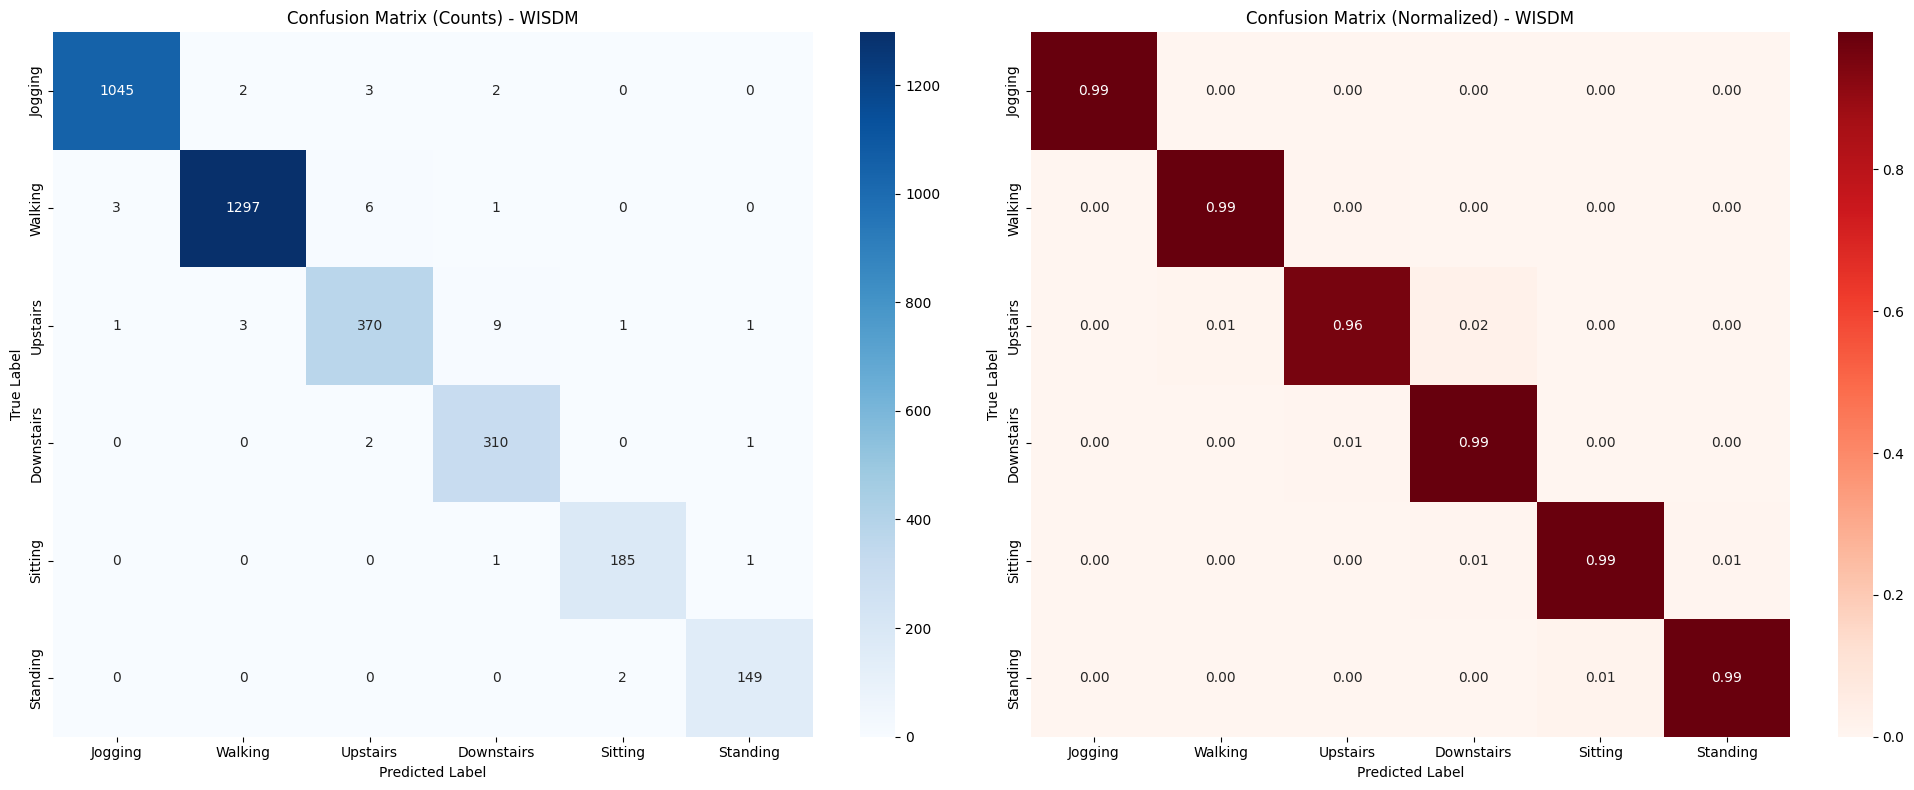

In [19]:
# -----------------------------------------------------------------------------
# [상세 분석 3] Confusion Matrix (Raw & Normalized)
# -----------------------------------------------------------------------------
plt.figure(figsize=(20, 8))

# 3-1. Raw Counts (개수 확인용)
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix (Counts) - {TARGET_DATASET}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3-2. Normalized (비율 확인용 - 헷갈리는 정도 파악)
plt.subplot(1, 2, 2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix (Normalized) - {TARGET_DATASET}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/figures/cm_{FILE_ID}.png')
print(f"   -> Saved CM plots to: results/figures/cm_{FILE_ID}.png")
plt.show()

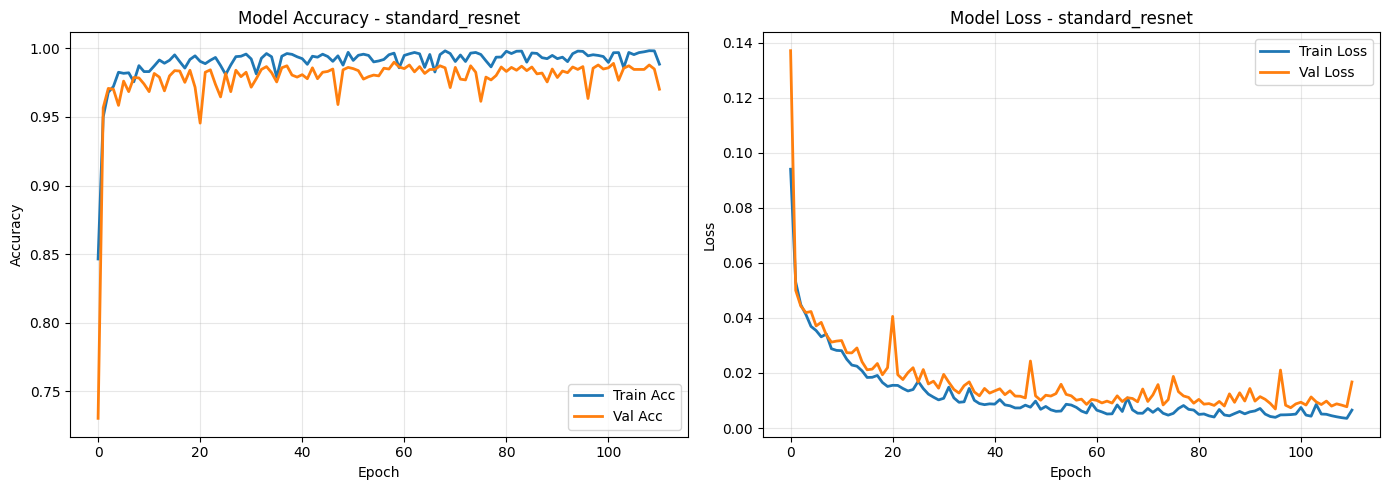

In [20]:
# -----------------------------------------------------------------------------
# [상세 분석 4] 학습 곡선 (Loss & Accuracy)
# -----------------------------------------------------------------------------
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.title(f'Model Accuracy - {TARGET_MODEL}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title(f'Model Loss - {TARGET_MODEL}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/figures/learning_curve_{FILE_ID}.png')
plt.show()